<h1> Generating Network Models

The code in this notebook generates the fractal and non-fractal network models described in [1].

**Module Imports**

In [9]:
# Network analysis modules
import networkx as nx
from igraph import Graph
import igraph

# Mathematics modules
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations
import itertools

# Utility modules
import os
from operator import itemgetter

<h2> Tutorial

There are several network models available in this notebook, namely:
- Song-Havlin-Makse model
- Hub Attraction Dynamical Growth model
- $(u, v)$-flowers
- Nested Barabási-Albert model

<h3> Song-Havlin-Makse (SHM) Model

A SHM network relies on two predetermined parameters, $m$ and $p$, and is generated as follows

1. Begin with two nodes connected by a single edge. 

2. At stage $t$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $t$, each edge in the $(t-1)$-th generation is removed randomly with independent probability $p$ and replaced with an edge between two of the new offspring at the endpoints of this edge.

This procedure is repeated $n$ times. 

**Generating Networks**

To generate a Song-Havlin-Makse network use `generate_SHM_model`.

In [679]:
# Generate a SHM network with m=5, p=0.4, n=3.
SHM_G = generate_SHM_model(5, 0.4, 3)

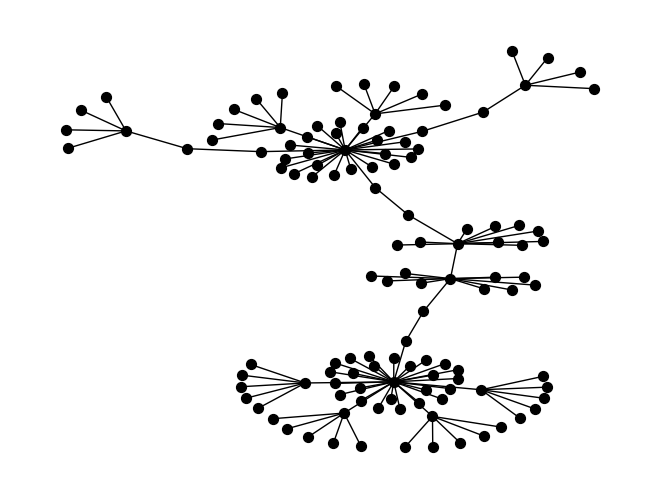

In [680]:
# Display the network
nx.draw_kamada_kawai(SHM_G, node_size=50, node_color = "black")
plt.show()

Alternatively, we can generate SHM networks for a variety of values of $p$. 

In [683]:
# Generate SHM networks with m=3, n=5 and take 21 probabilities, so that p = 0.0, 0.05, 0.10, ..., 0.95, 1.0
SHM_graphs = generate_SHM_model_for_all_p(3, 5, prob_N=21)

Both of the above methods take the optional Boolean argument `save`, which when `True` saves the networks to a gml file.

To find the file path to a saved SHM network use the function `retrieve_SHM_model`.

In [122]:
generate_SHM_model(6, 0.1, 3, save=True)
retrieve_SHM_model(6, 0.1, 3, example=1)

(<networkx.classes.graph.Graph at 0x1cfedc53fd0>,
 'network-files/models/SHM-model/SHM-model-6-0.1-generation3-example1.gml')

**General Properties of the Network**

The number of edges in a SHM network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (1+2m)^{n-1}.
\end{equation}

In [735]:
print(len(SHM_G.edges()))

121


This can also be calculated using `SHM_no_of_edges`.

In [746]:
# Calculate the number of edges in a SHM network with m=5, n=4.
print(SHM_no_of_edges(5, 3))

121


The number of nodes in a SHM network with parameters $m$ and $n$ is one more than the number of edges,
\begin{equation}
 v(G_n) = (1+2m)^{n-1} + 1.
\end{equation}

In [741]:
print(len(SHM_G.nodes()))

122


This can also be calculated using `SHM_no_of_nodes`.

In [748]:
# Calculate the number of nodes in a SHM network with m=5, n=4.
print(SHM_no_of_nodes(5, 3))

122


We can check that these expressions are true for given parameters $m$ and $n$ using `check_SHM_no_of_edges` and `check_SHM_no_of_nodes`.

In [694]:
# Check that the analytical expression for the number of edges is true for a network with m=3, n=6
check_SHM_no_of_edges(3, 6)

True

In [696]:
# Check that the analytical expression for the number of nodes is true for a network with m=3, n=6
check_SHM_no_of_nodes(3, 6)

True

**Analysing the Degree Distribution**

We can find deterministically the degree distribution of SHM networks for $p=0$ and $p=1$.

`SHM_p0_degree_prob(m, d, N)` finds the probability that a node has degree $d$ in a SHM network with parameters $m, N$ and $p=0$.
`SHM_p1_degree_prob(m, d, N)` does the same for $p=1$.

In a network with $p=0$, nodes can only have degree $(m+1)^k$ for some $k$.
In a network with $p=1$, nodes can only have degree $m^k$ or $2m^k$ for some $k$.

In [146]:
SHM_p0_degree_prob(2, 9, 7)

0.031997952131063614

In [148]:
SHM_p1_degree_prob(2, 9, 7)

0

In [150]:
SHM_p0_degree_prob(2, 4, 7)

0

In [152]:
SHM_p1_degree_prob(2, 4, 7)

0.09599385639319083

We can check that the calculated degree distribution is correct by comparing it to the true distribution of a generated network using `check_SHM_p0_degree_prob` and `check_SHM_p1_degree_prob`.

In [155]:
check_SHM_p0_degree_prob(2, 9, 7)

True

In [157]:
check_SHM_p1_degree_prob(2, 4, 7)

True

We can find the entire degree distribution with `SHM_p0_degree_dist(m, N)` and `SHM_p1_degree_dist(m, N)`.
The functions return a list of the degrees which appear in the network, and a list of their respective probabilities.

In [162]:
SHM_p0_degree_dist(4, 3)

([1, 5, 25], [0.8780487804878049, 0.0975609756097561, 0.024390243902439025])

In [166]:
SHM_p1_degree_dist(4, 3)

([1, 2, 4, 8, 16],
 [0.6585365853658537,
  0.21951219512195122,
  0.07317073170731707,
  0.024390243902439025,
  0.024390243902439025])

We can check the calculation with `check_SHM_p0_degree_dist(m, N)` and `check_SHM_p1_degree_dist(m, N)`.

In [171]:
check_SHM_p0_degree_dist(4, 3)

True

In [173]:
check_SHM_p1_degree_dist(4, 3)

True

This works for all values of $m$ and $N$.

In [176]:
correct = True
for N in [1,2,3,4,5]:
    for m in [2,3,4,5,6,7,8,9,10]:
        correct = correct and check_SHM_p0_degree_dist(m, N)
if correct:
    print("All distributions are correct!")

All distributions are correct!


In [178]:
correct = True
for N in [1,2,3,4,5]:
    for m in [2,3,4,5,6,7,8,9,10]:
        correct = correct and check_SHM_p1_degree_dist(m, N)
if correct:
    print("All distributions are correct!")

All distributions are correct!


SHM networks with parameters $p=0$ and $p=1$ are scale free, that is their degree distributions follow a power law of the form, 
\begin{equation} P(k) \approx k ^ {-\lambda}. \end{equation}
The value of $\lambda$ can be approximated by, 
\begin{equation}\lambda = \frac{\ln (1+2m)}{\ln (1+m)}, \end{equation} when $p=0$ and \begin{equation}\lambda = \frac{\ln (1+2m)}{\ln m}, \end{equation} when $p=1$.

We can compare the "true" value of $\lambda$ against the approximated value for $p=0$ using `check_SHM_p0_lambda'.

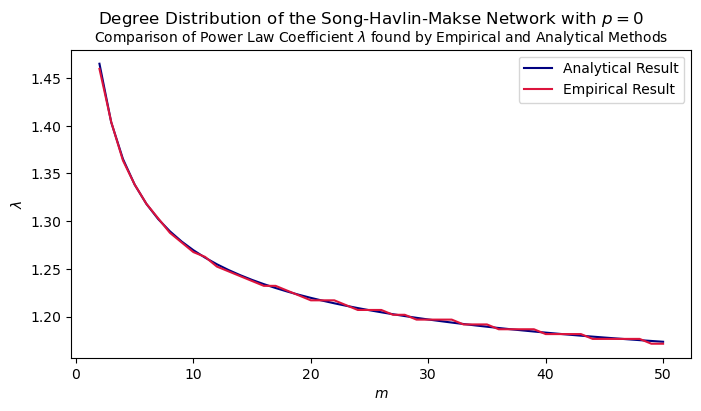

In [547]:
empirical, analytical = check_SHM_p0_lambda(10, 10, plot=True, verbose=False)

<h3> Hub Attraction Dynamical Growth (HADG) Model

The HADG model [4] is similar to the SHM model with some adaptations. It relies on predetermined parameters $a, b$ and $T$, where $0 \le a < b \le 1$ and $0 < T \le 1$.

1. Begin with two nodes connected by a single edge. 

2. At stage $t$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $t$, each edge $(u,v)$ in the $(t-1)$-th generation is removed randomly with independent probability
    \begin{align}
     p_{uv} = \begin{cases}
                 a, & \text{ if } \frac{d_{t-1}(u)}{d_{t-1}^\text{max}} > T \text{ and } \frac{d_{t-1}(v)}{d_{t-1}^\text{max}} > T, \\
                 b, & \text { otherwise.}
                 \end{cases}
    \end{align}
    where $d_{t-1}(x)$ is the degree of the node $x$ at time $t-1$ and $d_{t-1}^\text{max}$ is the maximum degree in the network at time $t-1$, and replaced with an edge between two of the new offspring at the endpoints of this edge.
    
4. At stage $t$, for each node $v$ in the $(t-1)$-th stage $d_{t-1}(v)$ edges are added between the new offspring of $v$.

This procedure is repeated $n$ times. 

**Generating Networks**

To generate a HADG model use `generate_HADG_model`.

In [720]:
# Generates a HADG network with m=4, a=0.5, b=0.7, T=0.2 and n=3.
HADG_G = generate_HADG_model(4, 0.5, 0.7, 0.2, 3)

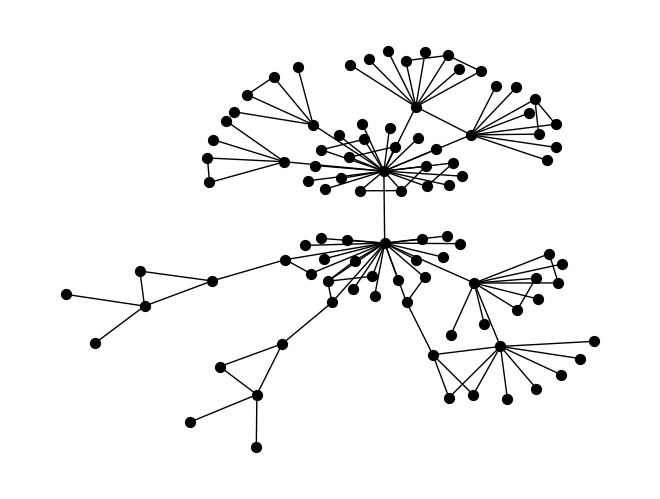

In [721]:
# Display the network
nx.draw_kamada_kawai(HADG_G, node_size=50, node_color = "black")
plt.show()

**General Properties of the Network**

The number of edges in a HADG network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (2m+3)^{n-1}.
\end{equation}

In [752]:
len(HADG_G.edges())

121

This can also be calculated with `HADG_no_of_edges`.

In [760]:
# Number of edges in a HADG network with m=4, n=3
HADG_no_of_edges(4, 3)

121

The number of nodes in a HADG network with parameters $m$ and $n$ is given by, 
\begin{equation}
 v(G_n) = 2 + \sum_{t=2}^{n} 2m \cdot (2m+3)^{t-2}.
\end{equation}

In [750]:
len(HADG_G.nodes())

98

This can also be calculated with `HADG_no_of_nodes`.

In [757]:
# Number of nodes in a HADG network with m=4, n=3
HADG_no_of_nodes(4, 3)

98

We can check that these expressions are true for given parameters $m$ and $n$ using `check_HADG_no_of_edges` and `check_HADG_no_of_nodes`.

In [766]:
# Check that the analytical expression for the number of edges is true for a network with m=5, n=4
check_SHM_no_of_edges(5, 4)

True

In [769]:
# Check that the analytical expression for the number of nodes is true for a network with m=5, n=4
check_SHM_no_of_nodes(5, 4)

True

<h3> $(u,v)$-Flowers

A $(u, v)$-flower [2], with $1\le u<v$, is generated as follows:

1. Begin with a cycle graph of length $w= u+v$.

2. In the $n$-th generation, replace each edge in the graph from the $(n-1)$-th generation with two parallel paths, one of length $u$ and the other of length $v$.

The networks are fractal when $u >1$ and non-fractal when $u=1$.

**Generating Networks**

The function `generate_uv_flower` generates a $(u,v)$ flower with parameters $u$, $v$ and $n$.

In [790]:
# Generate a 4th generation (2,3)-flower
fractal_flower_G = generate_uv_flower(2, 3, 4)

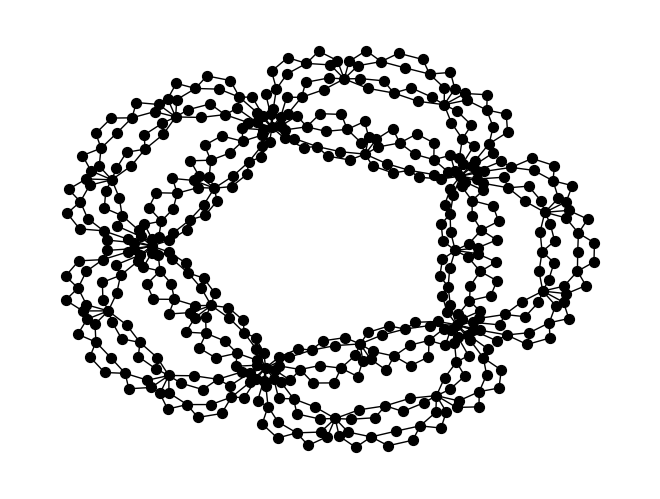

In [792]:
# Display the network
nx.draw_kamada_kawai(fractal_flower_G, node_size=50, node_color = "black")
plt.show()

To generate a non-fractal $(1, v)$-flower you can use `non_fractal_flower_G`. 

In [794]:
# Generate a 4th generation (1,3)-flower
non_fractal_flower_G = generate_non_fractal_uv_flower(3, 4)

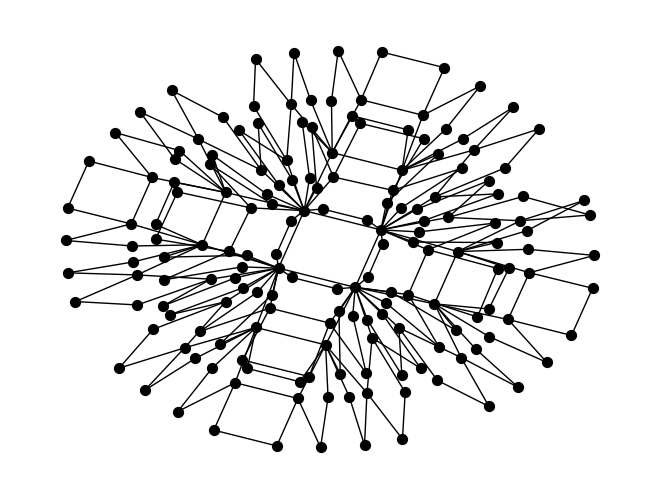

In [796]:
# Display the network
nx.draw_kamada_kawai(non_fractal_flower_G, node_size=50, node_color = "black")
plt.show()

**General Properties of the Network**

The number of edges in a $n$-th generation $(u,v)$-flower is given by, 
\begin{equation}
 e(G_n) = (u+v)^n.
\end{equation}

In [808]:
len(fractal_flower_G.edges())

625

In [809]:
len(non_fractal_flower_G.edges())

256

This can also be calculated with `uv_flower_no_of_edges`.

In [806]:
# Calculate the number of edges in a 4th generation (2,3)-flower
uv_flower_no_of_edges(2, 3, 4)

625

In [812]:
# Calculate the number of edges in a 4th generation (1,3)-flower
uv_flower_no_of_edges(1, 3, 4)

256

The number of nodes in a $n$-th generation $(u,v)$-flower is given by,
\begin{equation}
 v(G_n) = \frac{w-2}{w-1}w^n +\frac{w}{w-1},
\end{equation}
where $w = u+v$.

In [818]:
len(fractal_flower_G.nodes())

470

In [820]:
len(non_fractal_flower_G.nodes())

172

This can also be calculated with `uv_flower_no_of_nodes`.

In [831]:
# Calculate the number of nodes in a 4th generation (2,3)-flower
uv_flower_no_of_nodes(2, 3, 4)

470

In [833]:
# Calculate the number of nodes in a 4th generation (1,3)-flower
uv_flower_no_of_nodes(1, 3, 4)

172

We can check that these expressions are true for given parameters $u$, $v$ and $n$ using `check_uv_flower_no_of_edges` and `check_uv_flower_no_of_nodes`.

In [837]:
# Check that the analytical expression for the number of edges is true for a flower with u=2, v=5, n=4
check_uv_flower_no_of_edges(2, 5, 4)

True

In [839]:
# Check that the analytical expression for the number of nodes is true for a flower with u=2, v=5, n=4
check_uv_flower_no_of_nodes(2, 5, 4)

True

<h3> Nested Barabási-Albert (BA) Model

The Nested BA model [6] is based on the classic Barabási-Albert model and is generated as follows.

1. Generate a Barabási-Albert network with parameter $m$ which grows until the most connected node in the network has degree $k_\text{max}$

2. Choose a node $v$ with probability proportionate to its degree $k$.

3. Generate a Barabási-Albert network which grows until the most connected node in the network has degree $k$. Replace the node $v$ chosen in step 2 with this subnetwork. Reattach the edges of $v$ to nodes in the new subnetwork chosen uniformly at random. 

4. Repeat steps 2 and 3 until the network has order at least $N$.

**Generating Networks**

The function `generated_nested_BA_model` generates a nested BA network with parameters $m$, $N$ and $k_\max$.

In [848]:
# Generate a nested BA network with at least 100 nodes and parameters m=3 and kmax = 12
nested_BA_G = generate_nested_BA_model(3, 100, 12)

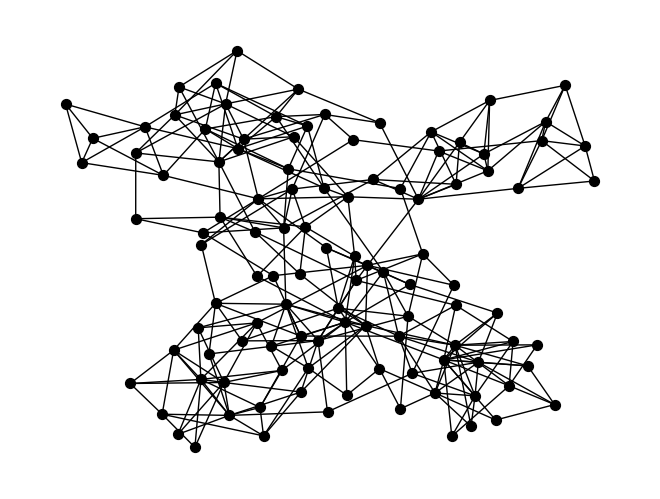

In [850]:
# Display the network
nx.draw_kamada_kawai(nested_BA_G, node_size=50, node_color = "black")
plt.show()

<h2> Workspace

In [15]:
random.randint(2500,3500)

2654

In [32]:
for _ in range(5):
    n = random.randint(2500,3500)
    m = random.randint(1,5)
    print(n, m)
    generate_barabasi_albert_network(m, n, save=True)

3465 1
3237 5
3309 5
3203 2
2644 4


This area of the workbook can be used to experiment with functions or write new code.

<h1>Functions

<h2> 1 Fractal Models

<h3> 1.1 Song-Havlin-Makse (SHM) Model

A SHM network relies on two predetermined parameters, $m$ and $p$, and is generated as follows

1. Begin with two nodes connected by a single edge. 

2. At stage $n$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $t$, each edge in the $(t-1)$-th generation is removed randomly with independent probability $p$ and replaced with an edge between two of the new offspring at the endpoints of this edge.

This procedure is repeated $n$ times. 

**Generate a $n$-th generation SHM network with parameters $m$ and $p$**

In [256]:
def generate_SHM_model(m, p, n, save=False):
    """
    Generates an n-th generation SHM network with parameters m and p.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [3].
        p (float): The probability of rewiring an edge, as defined by the SHM model [3]. The value of p should be between 0 and 1.
        n (int): The number of iterations to perform of the SHM generative process [3].
        save (bool) (opt): If True, the file is saved to the network-files folder. Default is False.
        
    Returns:
        G (networkx.Graph): The generated SHM network.
    """
    
    # In the first generation the network is a path of length 2. 
    G = nx.path_graph(2)
    
    # Generate the next generation n-1 more times. 
    for t in range(n-1):
        G = SHM_iteration(G, m, p)
        
    # Save the file is save is True.
    if save==True:
        # Save the file in the format SHM-model-m-p-generationn-examplei.gml
        # For p != 0 the method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved. 
        while saved == False:
            filename = "SHM-model-" + str(m) + "-" + str(p) + "-generation" + str(n) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/SHM-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
    
    # Return the generated graph
    return G

In [257]:
def SHM_iteration(G, m, p):
    """
    Performs one iteration of the generative process for the SHM model.
    
    Args:
        G (networkx.Graph): The network from the previous generation.
        m (int): The number of offspring added at each stage, as defined by the SHM model [3].
        p (float): The probability of rewiring an edge, as defined by the SHM model [3]. The value of p should be between 0 and 1.
        
    Returns:
        G (networkx.Graph): The network in the new generation.
    """
    # Find a list of all existing edges in the network.
    edges = list(G.edges())
    
    # For each edge, add m offspring to each endpoint of the edge.
    for edge in edges:
        G, source_offspring = add_m_offspring(G, edge[0], m)
        G, target_offspring = add_m_offspring(G, edge[1], m)
        
        # With probability p, rewire the original edge.
        if random.random() <= p:
            rewire_offspring(G, edge, source_offspring, target_offspring)
        
    # Return the updated network.
    return G

In [259]:
def add_m_offspring(G, node, m):
    """
    Adds m offspring to a given node, connected by a single edge.
    
    Args:
        G (networkx.Graph): The network in its current state.
        node (int): The node to which the offspring are to be added. 
        m (int): The number of offspring.
        
    Returns:
        G (networkx.Graph): The updated network.
        new_nodes (list): A list of the names of all the new nodes added at the previous stage.
    """
    # Find the number of nodes in the network
    N = len(G.nodes())
    
    # Add new nodes, named for the next available i integers.
    new_nodes = [N+i for i in range(m)]
    # Create a list of new edges, one connecting each new node to the original node.
    new_edges = zip(new_nodes, [node]*m)
    
    # Add the new edges and vertices
    G.add_nodes_from(new_nodes)
    G.add_edges_from(new_edges)
    
    # Return the updated graph, and a list of the new nodes.
    return G, new_nodes
    

In [262]:
def rewire_offspring(G, edge, source_offspring, target_offspring):
    """
    Rewires a given edge, replacing it with an edge between two randomly chosen offspring of the current endpoints [3].
    
    Args:
        G (networkx.Graph): The network in its current state.
        edge (tuple): The edge to be rewired.
        source_offspring (list): A list of offspring of the source node.
        target_offspring (list): A list of offspring of the target node.
        
    Returns:
        G (networkx.Graph): The updated network.        
    """
    # Remove the original edge.
    G.remove_edge(edge[0], edge[1])
    
    # Choose a new source at random from the original source node's offspring.
    new_source = random.choice(source_offspring)
    # Choose a new target at random from the original target node's offspring.
    new_target = random.choice(target_offspring)
    
    # Add a new edge between the new source and target.
    G.add_edge(new_source, new_target)
    
    # Return the updated network.
    return G

**Generating SHM Networks for Multiple Probabilities**

Sometimes it is useful to generate SHM networks with the same parameters $m$ and $N$, but with different rewiring probabilities $p$. This is particularly true since $p$ determines the network's fractality. 

In [265]:
def generate_SHM_model_for_all_p(m, n, prob_N=11, example_N=1, save=False):
    """
    Generate SHM networks for a fixed m and n, for multiple values of p. 
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [3].
        n (int): The number of iterations to perform of the SHM generative process [3].
        prob_N (int): The number of probabilities to generate the graph for. Default is 11, so will generate networks with p in [0.0, 0.1, 0.2, ..., 0.9, 1.0]
        example_N (int) (opt): The number of networks of each probability to generate. Default is 1. 
        save (Bool) (opt): If True, save each of the networks to a .gml file. Default is False.
    
    Returns:
        probabilities (numpy.ndarray): A list of the probabilities which are used.
        graphs (list): A list of lists of generated networks. The sublist graphs[i] contains graphs with p=probabilities[i].
    """
    # Generate the list of probabilities p.
    probabilities = np.linspace(0, 1, prob_N)
    
    # Initialise an empty list to store networks.
    graphs = []
    
    # Iterate for each probability.
    for p in probabilities:
        # Initialise an empty list to store networks with probability p.
        p_graphs = []
        # Generate such a network and add it to the list.
        for i in range(example_N):
            G = generate_SHM_model(m, p, n, save=save)
            p_graphs.append(G)
        # Add the list of networks with probability p to the overall list.
        graphs.append(p_graphs)
    
    # Return a list of probabilities and graphs.
    return probabilities, graphs

**Finding a Saved SHM Network File**

The following code provides a function `retrieve_SHM_model` which returns the filepath of an existing network file given parameters $m$, probability $p$ and generation $n$. If there are multiple example files, then the example number can be specified.

In [269]:
def retrieve_SHM_model(m, p, n, example=1):
    """
    Given the parameters m, p, n and the example number, retrieve the file containing the SHM network. 
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [3].
        p (float): The probability of rewiring an edge, as defined by the SHM model [3]. 
        n (int): The number of iterations to perform of the SHM generative process [3].
        example (int) (opt): In the case of multiple graphs with the same parameters, specifies the example wanted. Default is 1.
        
    Returns:
        G (networkx.Graph): The saved SHM network with the above specified parameters. 
        filepath + filename (str): The filepath to the network file.
    """
    
    # Find the filepath to the model with these parameters. 
    filename = "SHM-model-" + str(m) + "-" + str(p) + "-generation" + str(n) + "-example" + str(example) + ".gml"
    filepath = "network-files/models/SHM-model/"

    # Read the network.
    G = nx.read_gml(filepath+filename)
    
    # Return the networkx graph.
    return G, filepath+filename

<h3> 1.2 Hub Attractraction Dynamical Growth (HADG) Model

The HADG model [3] is similar to the SHM model with some adaptations. It relies on predetermined parameters $a, b$ and $T$.

1. Begin with two nodes connected by a single edge. 

2. At stage $t$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $t$, each edge $(u,v)$ in the $(t-1)$-th generation is removed randomly with independent probability
    \begin{align}
     p_{uv} = \begin{cases}
                 a, & \text{ if } \frac{d_{t-1}(u)}{d_{t-1}^\text{max}} > T \text{ and } \frac{d_{t-1}(v)}{d_{t-1}^\text{max}} > T, \\
                 b, & \text { otherwise.}
                 \end{cases}
    \end{align}
    where $d_{t-1}(x)$ is the degree of the node $x$ at time $t-1$ and $d_{t-1}^\text{max}$ is the maximum degree in the network at time $t-1$, and replaced with an edge between two of the new offspring at the endpoints of this edge.
    
4. At stage $t$, for each node $v$ in the $(t-1)$-th stage $d_{t-1}(v)$ edges are added between the new offspring of $v$.

This procedure is repeated $n$ times. 

In [147]:
def generate_HADG_model(m, a, b, T, n, save=False):
    """
    Generates an nth generation HADG network with parameters m, a, b and T [4][5].
    
    Args:
        m (int): The number of offspring added at each stage, as according to [5].
        a (float): The probability of rewiring an edge if node degree is over the threshold [5].
        b (float): The probability of rewiring an edge otherwise [5].
        T (float): The threshold as according to [5].
        n (int): The number of iterations to perform of the HADG generative process.
        save (Bool) (opt): If True, saved the resulting network to a gml file. Default is False.
        
    Returns:
        G (networkx.Graph): The resulting HADG network.
    """
    # In the first generation the network is a path of length 2. 
    G = nx.path_graph(2)
    
    # Apply the generative process n-1 more times. 
    for t in range(n-1):
        G = HADG_iteration(G, m, a, b, T)
        
    # Save the file is save is True.
    if save==True:
        # Save the file in the format HADG-model-m-a-b-T-generationn-examplei.gml
        # The method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved.
        while saved == False:
            filename = "HADG-model-" + str(m) + "-" + str(a) + "-" + str(b) + "-" + str(T) + "-generation" + str(n) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/HADG-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
    
    # Return the generated graph.
    return G

In [149]:
def HADG_iteration(G, m, a, b, T):
    """
    Performs one iteration of the HADG generative process [4][5]. 
    
    Args:
        G (networkx.Graph): The network in its current state. 
        m (int): The number of offspring added at each stage, as according to [5].
        a (float): The probability of rewiring an edge if node degree is over the threshold [5].
        b (float): The probability of rewiring an edge otherwise [5].
        T (float): The threshold as according to [5].
        
    Returns:
        G (networkx.Graph): The updated network.
    """
    # Initialise a dictionary where each node is a key and each value starts as an empty list. 
    # This dictionary will store a list of the newly added nodes to which a previously existing node is adjacent.
    new_node_dict = dict.fromkeys(list(G.nodes()), [])
    
    # Find a list of the edges in the previous generation.
    edges = list(G.edges())
    # Find a list of the node degrees in the previous generation.
    degrees = dict(G.degree())
    
    # Iterate through each of the edges in the previous generation. 
    for edge in edges:
        # Add m offspring to the source node of the edge.
        G, source_offspring = add_m_offspring(G, edge[0], m)
        # Add m offspring to the target node of the edge.
        G, target_offspring = add_m_offspring(G, edge[1], m)
        
        # Find the degree of the source node in the previous generation.
        degx = degrees[edge[0]]
        # Find the degree of the target node in the previous generation.
        degy = degrees[edge[1]]
        # Find the maximum degree in the previous generation.
        degmax = max([degrees[v] for v in degrees])
        
        # If the degree of both the source and target node, relative to the maximum degree, are over the threshold then
        #    rewire the edge with probability a.
        if degx/degmax > T and degy/degmax >T:
            if random.random() <= a:
                rewire_offspring(G, edge, source_offspring, target_offspring)
        # Otherwise rewire the edge with probability b.
        else:
            if random.random() <= b:
                rewire_offspring(G, edge, source_offspring, target_offspring)
                
        # Update the dictionary of new neighbours for the source node. 
        source_neighbours = new_node_dict[edge[0]].copy()
        source_neighbours.extend(source_offspring)
        new_node_dict[edge[0]] = source_neighbours
        
        # Update the dictionary of new neighbours for the target node.
        target_neighbours = new_node_dict[edge[1]].copy()
        target_neighbours.extend(target_offspring)
        new_node_dict[edge[1]] = target_neighbours
        
    # Iterate through each of the nodes from the previous generation.
    for node in new_node_dict:
        # Find the list of new neighbours for that node.
        neighbours = new_node_dict[node]
        # Find the degree of the node at the previous generation.
        deg = degrees[node]
        
        # Find all possible pairs of new neighbours, i.e. all possible edges between the new offspring of the node.
        possible_edges = [i for i in combinations(neighbours, 2)]
        
        # Choose d random new edges where d is the degree of the node at the previous stage.
        new_edges = random.sample(possible_edges, min(deg, len(possible_edges)))
        # Add these new edges to the network.
        G.add_edges_from(new_edges)
        
    # Return the updated network.
    return G

<h3> 1.3 $(u, v)$-Flowers

A $(u, v)$-flower [2], with $1<u<v$, is generated as follows:

1. Begin with a cycle graph of length $w= u+v$.

2. In the $t$-th stage, replace each edge in the graph from the $(t-1)$-th generation network with two parallel paths, one of length $u$ and the other of length $v$.

This network is self similar because the $n$-th generation network contains $w$ copies of the $(n-1)$-th generation.

The model is also deterministic.

In [343]:
def generate_uv_flower(u, v, n, save=False):
    """
    Generates an n-th generation (u,v)-flower.
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        save (bool) (opt): If True, the file is saved to the network-files folder. Default is False.
        
    Returns:
        G (networkx.Graph): The generated (u,v)-flower.
    """
    # Initialise a cycle graph of length w = u + v
    G = nx.cycle_graph(u+v)
    
    # For each of the n-1 remaining generations, perform one iteration of the generative process. 
    for i in range(n-1):
        G = uv_iteration(G, u, v)
     
    # Save the file in the format uvflower-generationn.gml
    if save:
        filename = str(u) + "_" + str(v) + "_flower-generation" + str(n) + ".gml"
        filepath = "network-files/models/uv-flowers/" + filename
        nx.write_gml(G, filepath)
    
    return G

In [344]:
def uv_iteration(G, u, v):
    """
    Performs one iteration in the (u,v)-flower generation process. 
    
    Args:
        G (networkx.Graph): The (u,v)-flower network in its current (t-1)-th generation. 
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        
    Returns:
        G (networkx.Graph): The (u,v)-flower network in the t-th generation. 
        
    """
    # Find a list of all the nodes and edges in the network at the (t-1)-th generation.
    nodes = list(G.nodes())
    edges = list(G.edges())
    
    # Remove all the existing edges. 
    G.remove_edges_from(G.edges())

    # Iterate through each of the edges from the network in the (t-1)-th generation.
    for edge in edges:
        # n is used to store the smallest integer which isn't yet a node label. 
        # The nodes are labelled 0, ..., n-1, so this is n.
        N = len(G.nodes())
        
        # Replace the edge with a path of length u.
        # First find a path graph using these vertices.
        Hu, N = add_new_path(u, N, edge)
        # Then merge this path graph with the existing network.
        G = nx.compose(G, Hu)
        
        # Replace the edge with a path of length v.
        # First find a path graph using these vertices.
        Hv, N = add_new_path(v, N, edge)
        # Then merge this path graph with the existing network.
        G = nx.compose(G, Hv)

    # Return the graph after all iterations. 
    return G

In [345]:
def add_new_path(l, N, edge):
    """
    Adds a new parallel path to the network, a step in the (u, v)-flower generation process. 
    
    Args:
        l (int): The length of the path to be added to the network.
        N (int): A counter which stores the next unused integer to label nodes. 
        edge (tuple): The edge from the network being replaced with parallel paths. 
        
    Returns:
        Hl (networkx.Graph): A path graph of length l with vertices labelled correctly. 
        N (int): A counter which stores the next unused integer to label nodes. 
    """
    # Generate a path graph with l edges (and l+1 vertices). 
    Hl = nx.path_graph(l+1)
    
    # Create an empty dictionary to be used to relabel the nodes in the path. 
    l_rlbl = {key:None for key in list(Hl.nodes)}
    
    # The nodes in the path graph are labelled from 0 to l. 
    # Thus, the node 0 in this path corresponds to the source node of the original edge,
    #   and the node l in this path corresponds to the target node of the original edge.
    
    # Iterate through all the nodes in the path.
    for node in list(Hl.nodes()):
        # If the node is 0 in the path, relabel it as the source of the original edge.
        if node == 0:
            l_rlbl[node] = edge[0]
        # If the node is l in the path, relabel it as the source of the original edge.
        elif node == l:
            l_rlbl[node] = edge[1]
        # For all other nodes, relabel it as the next unused integer. 
        else:
            l_rlbl[node] = N
            # Increment the counter n, so that n is now the next unused integer. 
            N += 1
            
    # Relabel the nodes according to the scheme described above. 
    Hl = nx.relabel_nodes(Hl, l_rlbl)
    
    # Return the path graph to be merged with the (u, v)-flower graph, and the counter for the next unused integer for node labels. 
    return Hl, N

<h3> 1.4 Nested Barabási-Albert (BA) Model

The Nested BA model [6] is based on the classic Barabási-Albert model and is generated as follows.

1. Generate a Barabási-Albert network with parameter $m$ which grows until the most connected node in the network has degree $k_\text{max}$

2. Choose a node $v$ with probability proportionate to its degree $k$.

3. Generate a Barabási-Albert network which grows until the most connected node in the network has degree $k$. Replace the node $v$ chosen in step 2 with this subnetwork. Reattach the edges of $v$ to nodes in the new subnetwork chosen uniformly at random. 

4. Repeat steps 2 and 3 until the network has order at least $N$.

In [351]:
def generate_nested_BA_model(m, N, kmax, save=False):
    """
    Generated a nested Barabasi-Albert (BA) network of order > N with parameters m, k [6].
    Some of this code is taken from the NetworkX barabasi_albert_graph function. 
    
    Args:
        m (int): The number of edges attached to a newly created node in the generation of a BA network.
        N (int): The minimum order (number of nodes) of the network. 
        kmax (int): The maximum degree of the original BA network [6].
        save (Bool) (opt): If True, saved the resulting network to a gml file. Default is False.
        
    Returns:
        G (networkx.Graph): The resulting nested BA network.
        
    """
    # Generate a BA network with maximum degree kmax
    G = generate_nested_BA_model_subnetwork(m, kmax)

    # Find the degree distribution of the network
    degrees = G.degree()
    # Create a list of nodes in the network where each node is repeated as many times as it has edges. 
    # This is used to select a node with probability proportional to its degree.
    repeated_nodes = [v for v, d in G.degree() for _ in range(d)]
    
    # Continue to generate the network while there are less than N nodes.
    while len(G) < N:
        # Choose a node at random from the list of repeated nodes, with probability proportionate to its degree.
        node = random.choice(repeated_nodes)
        
        # Generate a BA network with maximum degree k, where k is the degree of the chosen node.
        H = generate_nested_BA_model_subnetwork(m, G.degree(node))
        
        # Relabel the nodes in the new subnetwork, so that they can be added to the existing graph.
        # Nodes are labeled from 0 to N-1, so the next nodes should be numbered N, N+1, ...
        new_nodes = list(H.nodes())
        H = nx.relabel_nodes(H, dict(zip(new_nodes, [i + len(G) for i in new_nodes])))
        new_nodes = list(H.nodes()) # Take a list of the newly added nodes.
        
        # Each of the edges of the chosen node need to be removed and reattached to new nodes chosen at random.
        to_be_reconnected = [i for i in G.neighbors(node)] # Store each edges' source node
        G.remove_node(node) # Remove the chosen node
        G = nx.union(G, H) # Add the new subnetwork
        # For each source node, chose a random node from the newly added subnetwork and add an edge between them. 
        for source in to_be_reconnected:
            target = random.choice(new_nodes)
            G.add_edge(source, target)
        
        # Relabel the nodes so that they are numbered from 0 to N-1
        G = nx.convert_node_labels_to_integers(G,first_label=0)
        
        # Update the list of repeated nodes. 
        repeated_nodes = [v for v, d in G.degree() for _ in range(d)]
    
    # Save the file is save is True.
    if save==True:
        # Save the file in the format nested-BA-model-m-N-kmax-examplei.gml
        # For p != 0 the method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved. 
        while saved == False:
            filename = "nested-BA-model-" + str(m) + "-" + str(N) + "-" + str(kmax) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/nested-BA-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
        
    return G

In [8]:
def generate_nested_BA_model_subnetwork(m, kmax):
    """
    Generates a Barabasi-Albert (BA) network with maximum degree kmax.
    Some of this code is from the NetworkX barabasi_albert_graph function. 
    
    Args:
        m (int): The number of edges attached to a newly created node in the generation of a BA network.
        kmax (int): The maximum degree of the BA network.
        
    Returns:
        G (networkx.Graph): The generated BA network.
    """
    
    # Begin with a complete graph on m+1 nodes so that each node has m edges. 
    G = nx.complete_graph(m+1)

    # Generate a list of nodes where each node is repeated as many times as its degree. 
    degrees = G.degree()
    repeated_nodes = [n for n, d in degrees for _ in range(d)]
    
    # The label of the next node is the next available integer, which is N (nodes are labelled from 0 to N-1)
    next_node = len(G)
    
    # Find the maximum degree in the network
    k = max(degrees, key = lambda x: x[1])[1]
    
    # Iterate while the maximum degree is less than kmax
    while k < kmax:
        # Choose m target nodes in proportion to their degree. 
        target_nodes = preferential_choice(repeated_nodes, m)
        # Add edges between the new node and the m randomly chosen neighbours.
        G.add_edges_from(zip([next_node] * m, target_nodes))
        
        # Add each of the target nodes to the list of repeated nodes once, to represent their newly added edge.
        repeated_nodes.extend(target_nodes)
        # Add the new node m times to the list of repeated nodes. 
        repeated_nodes.extend([next_node] * m)
        
        # Calculate the new maximum degree
        degrees = G.degree()
        k = max(degrees, key = lambda x: x[1])[1]
        
        # Increment the label for the next node.
        next_node += 1
  
    # Once the maximum degree is kmax, return the generated network.
    return G
    

In [9]:
def preferential_choice(repeated_nodes, m):
    """
    Chooses m nodes at random with probability proportionate to their degree. 
    Some of this code is from the NetworkX barabasi_albert_graph function. 
    
    Args:
        repeated_nodes (list): A list of nodes where each node is repeated as many times as its degree. 
        m (int): The number of nodes to be chosen.
        
    Returns:
        target_nodes (set): A set of m chosen nodes. 
    """
    # Initialise an empty set for the target nodes. 
    # We use a set instead of a list so that the m nodes chosen are unique.
    target_nodes = set()
    
    # Iterate until m nodes are chosen. 
    while len(target_nodes) < m:
        # Choose a node at random from the list.
        # Because each node with degree k is repeated k times the probability of it being chosen is k/2e(G)
        x = random.choice(repeated_nodes)
        # Add the chosen node to the set. 
        # If the node has been chosen already, it will not be added again. 
        target_nodes.add(x)
        
    # Return the list of chosen nodes.
    return target_nodes


<h2> 2 Non-Fractal Models

<h3> 2.1 $(u, v)$-Flowers

It was shown in [1] that $(u, v)$-flowers with $u=1$ are non-fractal. The function `generate_non_fractal_uv_flower` generates an $n$-th generation non-fractal $(1, v)$-flower with parameter $v$. 

In [378]:
def generate_non_fractal_uv_flower(v, n):
    """
    Generates a non-fractal (u,v)-flower with u=1.
    
    Args:
        v (int): Value of v, i.e. path length of the parallel paths. 
        n (int): Number of generations.
        
    Returns:
        (networkx.Graph): The generated (u,v)-flower.
    """
    # Returns the (u,v)-flower found by the fractal generator, but with u hardcoded as 1. 
    return generate_uv_flower(1, v, n)

In [22]:
def generate_barabasi_albert_network(m, n, save=False):
    """
    Generates an n-th generation (u,v)-flower.
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        save (bool) (opt): If True, the file is saved to the network-files folder. Default is False.
        
    Returns:
        G (networkx.Graph): The generated (u,v)-flower.
    """
    # Initialise a cycle graph of length w = u + v
    G = nx.barabasi_albert_graph(n, m)
     
    # Save the file is save is True.
    if save==True:
        # Save the file in the format SHM-model-m-p-generationn-examplei.gml
        # For p != 0 the method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved. 
        while saved == False:
            filename = "BA-model-" + str(m) + "-" + str(n) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/barabasi-albert-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
    
    return G

<h2> 3 Verifying Properties

<h3> 3.1 SHM Model

<h4> 3.1.1 General Properties

**Order and Size**

The number of edges in a SHM network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (1+2m)^{n-1}.
\end{equation}

In [396]:
def SHM_no_of_edges(m, n):
    """
    Finds the number of edges in an n-th generation SHM network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        n (int): The number of iterations to perform of the SHM generative process [2].
        
    Returns:
        (int): The number of edges in the network.
    """
    # A SHM network has (1+2m)^(n-1) edges.
    return (1+2*m)**(n-1)

The number of vertices is one more than the number of edges:
\begin{equation}
 v(G_n) = (1+2m)^{n-1} + 1.
\end{equation}

In [404]:
def SHM_no_of_nodes(m, n):
    """
    Finds the number of nodes in an n-th generation SHM network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        n (int): The number of iterations to perform of the SHM generative process [2].
        
    Returns:
        (int): The number of nodes in the network.
    """
    # A SHM network has (1+2m)^(n-1)+1 nodes.
    return (1+2*m)**(n-1) + 1

To check that these calculations are correct, we can use `check_SHM_no_of_edges` and `check_SHM_no_of_nodes`.

In [551]:
def check_SHM_no_of_edges(m, n):
    """
    Checks the validity of the number of edges of a SHM network calculating according to analytical arguments in [1]
    
    Args:
        m (int): The parameter m in the SHM network model [3]
         n(int): The parameter n in the SHM network model [3]
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of edges is independent of the probability p, so p is chosen randomly on the interval [0,1]
    G = generate_SHM_model(m, random.random(), n, save=False)
    
    eG = len(G.edges()) # Empirical number of edges
    est_eG = SHM_no_of_edges(m, n) # Estimated number of edges
    
    # Check if the values are equal
    return eG == est_eG

In [442]:
def check_SHM_no_of_nodes(m, n):
    """
    Checks the validity of the number of nodes of a SHM network calculating according to analytical arguments in [1]
    
    Args:
        m (int): The parameter m in the SHM network model [3]
        n (int): The parameter n in the SHM network model [3]
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of nodes is independent of the probability p, so p is chosen randomly on the interval [0,1]
    G = generate_SHM_model(m, random.random(), n, save=False)
    
    N = len(G.nodes()) # Empirical number of nodes
    est_N = SHM_no_of_nodes(m, n) # Estimated number of nodes
    
    # Check if the values are equal
    return N == est_N

<h4> 3.1.2 Degree Distribution

**Degree Distribution for $p=0$**

The following code calculates, according to the analytical arguments of [4], the probability $P(d)$ for a degree $d$ in the probability distribution of a SHM network with parameters $m$, $N$ and $p=0$.

In [433]:
def SHM_p0_degree_prob(m, d, n):
    """
    Calculates the probability P(d) for a given degree d in a SHM network with parameters m, n and p=0.
    
    Args:
        m (int): The parameter m in the SHM network model [3]
        d (int): The degree to find the probability density P(d) for.
        n (int): The parameter N in the SHM network model [3]
        
    Returns:
        (float): The probability P(d) from the degree distribution.
    """
    # The maximum degree in a network with parameters m, N is (1+m)^(N-1) [4].
    # Thus for any larger degree d, the probability of a node having degree d is 0.
    if d > (1+m) ** (n-1):
        return 0
    
    # All degrees in a SHM network with p=0 are powers of (1+m)
    power, is_power = exact_log(d, (1+m)) # Check if d is a power of (1+m) and find the exponent.
    
    # If d is a power, then we can find P(d).
    if is_power:
        # Nodes added at stage k have degree d = (1+m)^power = (1+m)^(N-k), so k = N-power.
        k = n - power
        
        # In the first stage, 2 nodes are added.
        if k == 1:
            no_deg_d = 2
            
        # In every subsequent stage (1+2m)^(k-1) - (1+2m)^(k-2) nodes are added.
        else:
            no_deg_d = (1+2*m)**(k-1) - (1+2*m)**(k-2)
        
        # Find the total number of nodes in the network.
        total = SHM_no_of_nodes(m, n)
        
        # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
        return no_deg_d/total

    # For all other degrees, return 0.
    else:
        return 0

The accuracy of the above function can be checked with the following function. It generates a SHM network and checks that the true probability $P(d)$ for degree $d$ is the same as the one calculated by `SHM_p1_degree_prob`.

In [435]:
def check_SHM_p0_degree_prob(m, d, n):
    """
    Checks the accuracy of the calculated degree probability, according to analytical arguments in [1].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        n (int): The parameter N in the SHM network model [2]
        
    Returns:
        (Bool): True if the two values agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, n, p=0.
    G = generate_SHM_model(m, 0, n, save=False)
    
    # Find a list of the degrees in the network.
    degrees = [deg[1] for deg in G.degree()]
    
    # Count the number of nodes with degree d.
    no_deg_d = degrees.count(d)
    # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
    prob = no_deg_d/len(degrees)
    
    # Find the calculated probability according to the analytical arguments. 
    est_prob = SHM_p0_degree_prob(m, d, n)
    
    # Return True if the values agree, and False if not.
    return prob == est_prob

To calculate the entire degree distribution we need to calculate $P(d)$ for all possible $d$.

In [489]:
def SHM_p0_degree_dist(m, n):
    """
    Calculates the degree distribution of a SHM network with p=0
    
    Args:
        m (int): The parameter m in the SHM network model to test [2]
        n (int): The parameter N in the SHM network model [2]
        
    Returns: 
        degrees (list): A list of the degrees in the network.
        degree_dist (list): A list of probabilities of a node having a given degree. 
    """
    # Initialise empty lists for the degrees and the degree distribution
    degrees = []
    degree_dist = []
    
    # Iterate through each of the generative stages 1, 2, ..., N
    for k in range(n, 0, -1):
        # The degree of a node added at time k is (1+m)^(N-k)
        d = (1+m) ** (n-k)
        # Add the degree d to the list of degrees.
        degrees.append(d)
        # Add the probability P(d) to the degree distribution.
        degree_dist.append(SHM_p0_degree_prob(m, d, n))
        
    # Return the list of degrees and the degree distribution.
    return degrees, degree_dist

The accuracy of `SHM_p0_degree_dist` is checked using `check_SHM_p0_degree_dist`.

In [445]:
def check_SHM_p0_degree_dist(m, n):
    """
    Checks the accuracy of the calculated degree distribution, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        n (int): The parameter n in the SHM network model [2]
        
    Returns:
        (Bool): True if the two distributions agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=0.
    G = generate_SHM_model(m, 0, n, save=False)
    # Find the degree distribution.
    degrees = [deg[1] for deg in G.degree()]
    
    # Find a sorted list of degrees without repetition.
    unique_degrees = list(set(degrees))
    unique_degrees.sort()
    
    # Initialise an empty list for the degree distribution.
    degree_dist = []
    
    # For each of the degrees, find the number of occurrences and divide that by the total number of nodes.
    for d in unique_degrees:
        no_deg_d = degrees.count(d)
        prob = no_deg_d/len(degrees)
        # Add the probability to the degree distribution
        degree_dist.append(prob)
    
    # Find the estimated degree distribution according to the analytical arguments. 
    _, est_degree_dist = SHM_p0_degree_dist(m, n)
    
    # Return True if the distributions are the same, and False otherwise. 
    return degree_dist == est_degree_dist

**Degree Distribution for $p=1$**

The following code calculates, according to the analytical arguments of [4], the probability $P(d)$ for a degree $d$ in the probability distribution of a SHM network with parameters $m$, $N$ and $p=1$.

In [476]:
def SHM_p1_degree_prob(m, d, n):
    """
    Calculates the probability P(d) for a given degree d in a SHM network with parameters m, N and p=1.
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        n (int): The parameter n in the SHM network model [2]
        
    Returns:
        (float): The probability P(d) from the degree distribution.
    """
    # The maximum degree in a network with parameters m, N is m^(N-1) [4].
    # Thus for any larger degree d, the probability of a node having degree d is 0.
    if d > (m) ** (n-1):
        return 0
    
    # All degrees in a SHM network are powers of m or 2 times a power of m.
    power, is_power = exact_log(d, m) # Check if d is a power of m, and find the exponent.
    double_power, is_double_power = exact_log(d/2, m) # Check if 1/2 d is a power of m, and find the exponent. 
    
    # The only case where d and 1/2 are both powers of m is when m = 2.
    # In this case, the calculation of the degree distribution is different. 
    if is_power and is_double_power:
        # Find k, where k is the stage that the node is added. 
        # The degree of the node is d=m^(N-k), so if d=m^power, then power = N-k
        k = n - power
        
        # If the node was added in the first stage, or if the node was added in the second stage by rewired, then k=1.
        if k == 1:
            # There are four such nodes, the 2 added in the first stage and the 2 rewired in the second stage.
            no_deg_d = 4
            
        # If the node was added in any other stage, then calculate the number of nodes with this degree.
        else:
            # There are 2(m-1)(1+2m)^(k-2) nodes added in the k-th stage which aren't rewired,
            #            and 2(1+2m)^(k-1) nodes added in the (k+1)-th stage which are rewired.
            no_deg_d = 2 * (m-1) * (1+2*m)**(k-2) + 2 * (1+2*m)**(k-1)  
        
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, n)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # The remaining code deals with all other cases when m != 2.
    
    # If d is a power of m, then d is the degree of a node added in the k-th stage which is not rewired, 
    #    where k is such that d = m ^ (n-k)
    elif is_power:
        # Find k
        k = n - power
        
        # If the node was added in the first stage then k=1.
        if k == 1:
            # There are two nodes added in the first stage.
            no_deg_d = 2
            
        # Otherwise, the number of nodes added in the k-th stage which aren't rewired is 2(m-1)(1+2m)^(k-2).
        else:
            no_deg_d = 2 * (m-1) * (1+2*m)**(k-2)
            
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, n)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # If 1/2 d is a power of m, then d is the degree of a node added in the k-th stage which is rewired, 
    #    where k is such that d = 2 m ^ (n-k)
    elif is_double_power:
        # Find k
        k = n - power
        
        # No nodes are rewired in the first stage, so we do not need to consider that case.
        no_deg_d = 2 * (1+2*m)**(k-2)
        
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, n)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # If the degree d is a not a power of m, or 1/2 d is not a power of m, then no nodes will have degree d.
    # Thus the probability is 0.
    else:
        return 0

The accuracy of the above function can be checked with the following function. It generates a SHM network and checks that the true probability $P(d)$ for degree $d$ is the same as the one calculated by `SHM_p1_degree_prob`.

In [478]:
def check_SHM_p1_degree_prob(m, d, n):
    """
    Checks the accuracy of the calculated degree probability, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        n (int): The parameter n in the SHM network model [2]
        
    Returns:
        (Bool): True if the two values agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=1.
    G = generate_SHM_model(m, 1, n, save=False)
    
    # Find a list of the degrees in the network.
    degrees = [deg[1] for deg in G.degree()]
    
    # Count the number of nodes with degree d.
    no_deg_d = degrees.count(d)
    # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
    prob = no_deg_d/len(degrees)
    
    # Find the calculated probability according to the analytical arguments. 
    est_prob = SHM_p1_degree_prob(m, d, n)
    
    # Return True if the values agree, and False if not.
    return prob == est_prob

To calculate the entire degree distribution we need to calculate $P(d)$ for all possible $d$.

In [481]:
def SHM_p1_degree_dist(m, n):
    """
    Calculates the degree distribution of a SHM network with p=0
    
    Args:
        m (int): The parameter m in the SHM network model to test [2]
        n (int): The parameter n in the SHM network model [2]
        
    Returns: 
        degrees (list): A list of the degrees in the network.
        degree_dist (list): A list of probabilities of a node having a given degree, where degree_dist[i] is P(degrees[i])
    """
    # Initialise empty lists for the degrees and degree distribution. 
    degrees = []
    degree_dist = []

    # The degree distribution behaves different for m=2, so we consider this case separately.
    if m == 2:
        # Iterate through each of the generative stages 1, 2, ..., N
        for k in range(n, 0, -1):
            # The degree of nodes generated at stage k is m^(N-k)
            # For m=2, nodes generates at stage k+1 which are rewired also have degree m^(N-k)
            d = (m) ** (n-k)
            
            # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
            degrees.append(d)
            degree_dist.append(SHM_p1_degree_prob(m, d, n))
            
    # The following code deals with the case when m != 2.
    else:
        # Iterate through each of the generative stages 1, 2, ..., N
        for k in range(n, 0, -1):
            
            # The degree of nodes generated at stage k is m^(N-k)
            d = (m) ** (n-k)
            # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
            degrees.append(d)
            degree_dist.append(SHM_p1_degree_prob(m, d, n))
            
            # For all stages except the first, there are also some nodes which are rewired. 
            # These have degree 2m^(N-k)
            if not k ==1 :
                d = 2*(m) ** (n-k)
                
                # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
                degrees.append(d)
                degree_dist.append(SHM_p1_degree_prob(m, d, n))
    
    # Return the list of degrees and the degree distribution.
    return degrees, degree_dist

The accuracy of `SHM_p1_degree_dist` is checked using `check_SHM_p1_degree_dist`.

In [454]:
def check_SHM_p1_degree_dist(m, n):
    """
    Checks the accuracy of the calculated degree distribution, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        n (int): The parameter n in the SHM network model [2]
        
    Returns:
        (Bool): True if the two distributions agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=1.
    G = generate_SHM_model(m, 1, n, save=False)
    # Find the degree distribution.
    degrees = [deg[1] for deg in G.degree()]
    
    # Find a sorted list of degrees without repetition.
    unique_degrees = list(set(degrees))
    unique_degrees.sort()
    
    # Initialise an empty list for the degree distribution.
    degree_dist = []
    
    # For each of the degrees, find the number of occurrences and divide that by the total number of nodes.
    for d in unique_degrees:
        no_deg_d = degrees.count(d)
        prob = no_deg_d/len(degrees)
        # Add the probability to the degree distribution
        degree_dist.append(prob)
    
    # Find the estimated degree distribution according to the analytical arguments. 
    _, est_degree_dist = SHM_p1_degree_dist(m, n)

    # Return True if the distributions are the same, and False otherwise. 
    return degree_dist == est_degree_dist

**Scale-Free Property**

If the SHM network is scale-free then its degree distribution follows a power law of the form $P(k) \sim Ak^{\lambda}$ where $A$ and $\lambda$ are constants. Analytical arguments in [4] show that we expect the value of $\lambda$ to be, 
\begin{equation}\lambda = \frac{\ln (1+2m)}{\ln (1+m)}, \end{equation} when $p=0$.

In [586]:
def check_SHM_p0_lambda(m_max, n, plot=False, verbose=False):
    """
    Verfies that the analytical result for lambda agrees with the empirical result. 
    
    Args:
        m (int): The maximum value of parameter m in the SHM network model to test [2]
        n (int): The parameter n in the SHM network model [2]
        plot (Bool) (opt): If True, plots a comparison of the results. Default is False.
        verbose (Bool) (opt): If True, prints results to terminal. Default is False. 
        
    Returns:
        empirical (list): A list of the values of lambda found by fitting a power law distribution to empirical data.
        analystical (list): A list of the values of lambda determined by the analytical argument in [4]
    """
     
    # Initialise empty lists to store the empirical and analytical results.
    empirical = []
    analytical = []
    power = []
    
    # Create a list of all possible values of m
    ms = [m for m in range(2, m_max+1)]
    
    # Iterate over each possible m
    for m in ms:
        # Find the degree distribution
        degrees, degree_dist = SHM_p0_degree_dist(m, n)
        # Fit a power law curve to the distribution and find the parameters characterising the best fit
        best_fit, _ = find_best_power_law_fit(degrees, degree_dist, A_min=0.5, A_max=1.2, c_min = 1, c_max = 1.5, linspace_N=1001)
        # Calculate the estimated value of lambda according to analytical results.
        est_lambda = math.log(1+2*m) / math.log(1+m)
        
        # Add the results to their respective lists. 
        empirical.append(best_fit[1])
        analytical.append(est_lambda)
    
    # If verbose is True print the results.
    if verbose:
        print("Analytical Result", analytical)
        print("Empirical Result", empirical)
        
    # If plot is True plot the results. 
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(ms, analytical, label="Analytical Result", color ="navy")
        plt.plot(ms, empirical, label="Empirical Result", color ="crimson")
        plt.suptitle("Degree Distribution of the Song-Havlin-Makse Network with $p=0$")
        plt.title("Comparison of Power Law Coefficient $\lambda$ found by Empirical and Analytical Methods", fontsize=10)
        plt.xlabel("$m$")
        plt.ylabel("$\lambda$")
        plt.legend()
        plt.show()
    
    # Return the results from both methods as lists. 
    return empirical, analytical

<h3> 3.2 HADG Model

<h4> 3.2.1 General Properties

**Order and Size**

The number of edges in a HADG network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (2m+3)^{n-1}.
\end{equation}

In [618]:
def HADG_no_of_edges(m, n):
    """
    Finds the number of edges in an n-th generation HADG network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the HADG model [2].
        n (int): The number of iterations to perform of the HADG generative process [2].
        
    Returns:
        (int): The number of edges in the network.
    """
    # A HADG network has (3+2m)^(n-1) edges.
    return (3+2*m)**(n-1)

The number of nodes in a HADG network with parameters $m$ and $n$ is given by, 
\begin{equation}
 v(G_n) = 2 + \sum_{t=2}^{n} 2m \cdot (2m+3)^{t-2}.
\end{equation}

In [609]:
def HADG_no_of_nodes(m, n):
    """
    Finds the number of nodes in an n-th generation HADG network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the HADG model [2].
        n (int): The number of iterations to perform of the HADG generative process [2].
        
    Returns:
        N (int): The number of nodes in the network.
    """
    # Calculate the number of nodes
    N = 2
    
    for t in range(2, n+1):
        N += 2*m*((2*m+3)**(t-2))
         
    return N

To check that these calculations are correct, we can use `check_HADG_no_of_edges` and `check_HADG_no_of_nodes`.

In [607]:
def check_HADG_no_of_edges(m, n):
    """
    Checks the validity of the number of edges of a HADG network calculating according to analytical arguments in [1]
    
    Args:
        m (int): The parameter m in the HADG network model [3]
        n(int): The parameter n in the HADG network model [3]
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of edges is independent of the parameters a, b and T, so they are chosen randomly on the interval [0,1]
    G = generate_HADG_model(m, random.random(), random.random(), random.random(), n, save=False)
   
    eG = len(G.edges()) # Empirical number of edges
    est_eG = HADG_no_of_edges(m, n) # Estimated number of edges
    
    # Check if the values are equal
    return eG == est_eG

In [639]:
def check_HADG_no_of_nodes(m, n):
    """
    Checks the validity of the number of nodes of a HADG network calculating according to analytical arguments in [1]
    
    Args:
        m (int): The parameter m in the HADG network model [3]
        n(int): The parameter n in the HADG network model [3]
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of edges is independent of the parameters a, b and T, so they are chosen randomly on the interval [0,1]
    G = generate_HADG_model(m, random.random(), random.random(), random.random(), n, save=False)
   
    N = len(G.nodes()) # Empirical number of edges
    est_N = HADG_no_of_nodes(m, n) # Estimated number of edges
    
    # Check if the values are equal
    return N == est_N

<h3> 3.3 $(u,v)$-Flowers

<h4> 3.3.1 General Properties

**Order and Size**

The number of edges in a $n$-th generation $(u,v)$-flower is given by, 
\begin{equation}
 e(G_n) = (u+v)^n.
\end{equation}

In [620]:
def uv_flower_no_of_edges(u, v, n):
    """
    Finds the number of edges in an n-th generation (u,v)-flower network.
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        
    Returns:
        (int): The number of edges in the network.
    """
    # A (u,v)-flower has (u+v)^n edges.
    return (u+v)**n

The number of nodes in a $n$-th generation $(u,v)$-flower is given by,
\begin{equation}
 v(G_n) = \frac{w-2}{w-1}w^n +\frac{w}{w-1},
\end{equation}
where $w = u+v$.

In [829]:
def uv_flower_no_of_nodes(u, v, n):
    """
    Finds the number of nodes in an n-th generation (u,v)-flower network.
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        
    Returns:
        (int): The number of nodes in the network.
    """
    # Calculate the number of nodes
    
    w = u + v
    return int(((w-2)/(w-1))*(w**n) + (w/(w-1)))

To check that these calculations are correct, we can use `check_uv_flower_no_of_edges` and `check_uv_flower_no_of_nodes`.

In [628]:
def check_uv_flower_no_of_edges(u, v, n):
    """
    Checks the validity of the number of edges of a (u,v)-flower network calculating according to analytical arguments in [1]
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of edges is independent of the parameters a, b and T, so they are chosen randomly on the interval [0,1]
    G = generate_uv_flower(u, v, n)
   
    eG = len(G.edges()) # Empirical number of edges
    est_eG = uv_flower_no_of_edges(u, v, n) # Estimated number of edges
    
    # Check if the values are equal
    return eG == est_eG

In [648]:
def check_uv_flower_no_of_nodes(u, v, n):
    """
    Checks the validity of the number of edges of a (u,v)-flower network calculating according to analytical arguments in [1]
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        n (int): Number of generations.
        
    Returns:
        (Bool): True if the analytical and empirical value agree, False otherwise. 
    """    
    # Generate an SHM network. The number of edges is independent of the parameters a, b and T, so they are chosen randomly on the interval [0,1]
    G = generate_uv_flower(u, v, n)
   
    N = len(G.nodes()) # Empirical number of edges
    est_N = uv_flower_no_of_nodes(u, v, n) # Estimated number of edges
    
    # Check if the values are equal
    return N == est_N

<h1> 4 Utilities

The functions in this section are those which perform routine calculations.

<h2> 4.1 Utility Functions </h2>
    

`exact_log` returns True and the exact value of $\log_y(x)$ if $x$ is a power of $y$. 
If $x$ is not a power of $y$, it returns False and the greatest power of $y$ which divides $x$.

In [495]:
def exact_log(x, y):
    """
    Finds the exact logarithm of x base y.
    
    Args:
        x (int): The value of x.
        y (int): The logarithm base.
        
    Returns:
        power (int): The floor of the power, where y^power = x.
        x==1 (Bool): True if x is an exact power of y, False otherwise. 
    """
    power = 0
    while (x%y == 0):
        x = x/y
        power += 1
    return power, x==1

<h2> 4.3 Checking Power-Laws

To check the exponent $\lambda$ for scale-free networks we need to fit a power-law to the degree distribution. 

`find_best_power_law_fit` optimises the parameters $A$ and $c$ to find a best fit of the form, 
\begin{equation}
    y = A x ^{-c},
\end{equation}
by minimising the sum of squares error calculated by `sum_of_squares_error`.

In [130]:
def find_best_power_law_fit(x, y, A_min=0, A_max=10000, c_min = 0, c_max = 12.5, linspace_N=100):
    """
    Finds the best exponential fit according to the sum of squares deviation of the form y = Ax^{-c}
    
    Args: 
        x (list): The values of x in the distribution.
        y (list): The values of y in the distribution.
        A_min (int) (opt): The minimum value of A to be tested. Can be adjusted to find more accurate results. Default is 0.
        A_max (int) (opt): The maximum value of A to be tested. Can be adjusted to find more accurate results. Default is 10000.
        c_min (int) (opt): The minimum value of c to be tested. Can be adjusted to find more accurate results. Default is 0. 
        c_max (int) (opt): The maximum value of c to be tested. Can be adjusted to find more accurate results. Default is 12.5. 
        linspace_N (int) (opt): The number of values of A and c to be checked in the respective ranges. Default is 100.
        
    Returns:
        best_fit (tuple): The coefficients A and c from the best power law approximation. 
        best_score (float): The sum of squares regression of this approximation.
    """
    # Initialise empty variables for the best fit (i.e. best A and c) and the best SSR score. 
    best_fit = (None, None)
    best_score = None
    
    # Iterate through linspace_N values of A in the range [A_min, A_max].
    for A in np.linspace(A_min, A_max, 100):
        # Iterate through linspace_N values of c in the range [c_min, c_max].
        for c in np.linspace(c_min, c_max, 100):
            
            # Find the values of y according to the power law fractal model with parameters A and c.
            est_y = [A * i ** (-c) for i in x]
            # Calculate the sum of squares regression.
            score = sum_of_squares_error(y, est_y)
            
            # If the best score is yet to be updated (i.e. this is the first iteration) then set the current A, c and SSR to the best fit values.
            if best_score == None:
                best_score = score
                best_fit = (A, c)
            # If the new SSR score is smaller than the current best, then update the best score and update the best fit to the current A and c.
            elif score < best_score:
                best_score = score
                best_fit = (A, c)
    
    # Once all values are tried return the best fit and the best score.
    return best_fit, best_score

In [126]:
def sum_of_squares_error(y, est_y):
    """ 
    Finds the value SSR for the sum of squares regression method using a true and model distribution. 
    
    Args:
        y (list): The true or measured distribution.
        est_y (list): The model distribution to be compared. 
    
    Returns:
        sum_of_squares (float): The sum of squares regression
    """
    sum_of_squares = 0 # Initialise the sum as zero.
    # Iterate for each pair of values in the true/model distributions. 
    for (yi, est_yi) in zip(y, est_y):
        # Add to the sum the square of the difference between the two distributions. 
        sum_of_squares += (est_yi - yi) ** 2
    # Return the total sum of the squares. 
    return sum_of_squares

<h1> References

[1] K. Hamilton, "Origins of Fractality in Complex Networks" *MSc Thesis* 

[2] H. D. Rozenfeld, L. K. Gallos, C. Song, and H. A. Makse, “Fractal and transfractal scale-free networks,” in
Encyclopedia of Complexity and Systems Science. Springer New York, 2009, pp. 3924–3943

[3] C. Song, S. Havlin, and H. A. Makse, “Origins of fractality in the growth of complex networks,” Nature Physics,
vol. 2, pp. 275–281, 2006.

[4] L. Kuang, B. Zheng, D. Li, Y. Li, Y. Sun, "A fractal and scale-free model of complex networks with hub attraction behaviors," Science China Information Sciences, vol. 58, pp. 1–10, 2015. 

[5] E. Zakar-Poly ́ak, M. Nagy, and R. Molontay, “Towards a better understanding of the characteristics of fractal
networks,” Applied Network Science, vol. 8, pp. 1–34, 2022

[6] Fronczak, A. et al. “Scaling theory of fractal complex networks”. In: Scientific Reports 14.1, 2024